In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.signal import savgol_filter
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.signal import savgol_filter
import logging

logger = logging.getLogger(__name__)

In [ ]:
joint_positions = pd.read_csv("joint_positions.csv")

In [65]:
# Initialize dictionary to store per-patient DataFrames
patient_data = {}

# Loop over each unique patient/therapist
for patient_id in joint_positions['Patient'].unique():
    print(f"Processing patient/therapist: {patient_id}")
    
    # Subset data for the current patient
    df_patient = joint_positions[joint_positions['Patient'] == patient_id]

    df_pivot = df_patient.pivot_table(index='Frame', columns='Joint', values='Y')

    # Reset index so Frame becomes a column, not the index
    df_pivot.reset_index(inplace=True)

    # Rename columns: e.g., 'LHip' → 'Y_LHip'
    df_pivot.columns = ['Frame'] + [f"Y_{joint}" for joint in df_pivot.columns if joint != 'Frame']

    # Save the DataFrame to the patient_data dictionary
    patient_data[patient_id] = df_pivot
    print(f"Patient {patient_id} data shape: {df_pivot.shape}")

print("="*50)

# Combine all patient DataFrames into one
df_list = []

for patient_id, df_pivot in patient_data.items():
    df_temp = df_pivot.copy()
    df_temp['Patient'] = patient_id  # Add patient ID column
    df_list.append(df_temp)

# Concatenate all patient data vertically
df_all = pd.concat(df_list, axis=0)

print(f"Combined data shape (before dropping NAs): {df_all.shape}")

# Check missing values per column
na_counts = df_all.isna().sum()
na_percent = na_counts / len(df_all)

# Display columns with missing values
na_counts_sorted = na_counts[na_counts > 0].sort_values(ascending=False)
print("Columns with missing values sorted by count:")
print(na_counts_sorted)

# Drop columns with more than 30% missing values
cols_to_drop = na_percent[na_percent > 0.3].index
df_all.drop(columns=cols_to_drop, inplace=True)
# Reorder columns
cols = ['Patient', 'Frame'] + [col for col in df_all.columns if col not in ['Patient', 'Frame']]
df_all = df_all[cols]

print(f"\nDropped columns with >30% missing values: {list(cols_to_drop)}")
print(f"Remaining columns: {df_all.columns.tolist()}")
print(f"Final data shape: {df_all.shape}")


Processing patient/therapist: Patient_1
Patient Patient_1 data shape: (5207, 27)
Processing patient/therapist: Therapist_1
Patient Therapist_1 data shape: (3727, 27)
Processing patient/therapist: Therapist_2
Patient Therapist_2 data shape: (4038, 27)
Combined data shape (before dropping NAs): (12972, 28)
Columns with missing values sorted by count:
Y_Background    11830
Y_LHeel          8000
Y_LKnee          7857
Y_REye           7540
Y_REar           7488
Y_LBigToe        7301
Y_RBigToe        5867
Y_LEar           5287
Y_LSmallToe      5147
Y_LEye           5095
Y_LAnkle         4765
Y_RSmallToe       425
Y_RHeel           409
Y_Neck            306
Y_RShoulder       304
Y_RElbow          299
Y_Nose            285
Y_RWrist          285
Y_RKnee           271
Y_RHip            269
Y_LShoulder       267
Y_MidHip          256
Y_LElbow          252
Y_LWrist          222
dtype: int64

Dropped columns with >30% missing values: ['Y_Background', 'Y_LAnkle', 'Y_LBigToe', 'Y_LEar', 'Y_LEye', 'Y_

In [113]:
df_all

,Patient,Frame,Y_LElbow,Y_LHip,Y_LShoulder,Y_LWrist,Y_MidHip,Y_Neck,Y_Nose,Y_RAnkle,Y_RElbow,Y_RHeel,Y_RHip,Y_RKnee,Y_RShoulder,Y_RSmallToe,Y_RWrist
0,Patient_1,5,73.752266,106.493454,72.848850,62.176530,74.707245,68.250220,76.533104,68.796840,64.288260,149.10570,80.417670,83.27298,66.30859,132.375580,71.883156
1,Patient_1,6,73.733440,103.811980,72.817764,62.211044,74.710070,68.265175,76.558914,68.792534,64.414300,132.43835,80.400154,83.26392,66.36317,116.355230,71.859840
2,Patient_1,7,74.688896,102.860374,74.053910,62.476482,74.597660,69.870330,78.160120,69.206840,66.065155,133.22400,81.392570,84.27009,68.01537,119.050890,73.248634
3,Patient_1,8,75.169075,100.125305,74.572920,63.493640,74.592735,70.514980,78.432010,65.965576,67.097560,137.52193,81.603546,84.50434,68.83546,121.064224,73.775930
4,Patient_1,9,75.578510,99.236960,74.956024,64.236820,74.606900,70.809990,78.703476,66.064600,67.564910,139.02713,81.999800,84.78741,69.18241,121.829320,74.103920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033,Therapist_2,11780,166.971830,173.316650,168.157440,169.151890,164.379670,170.865780,176.916000,196.320900,170.806850,268.56482,181.349820,180.10020,170.76831,285.960400,169.397830
4034,Therapist_2,11781,166.402830,173.478560,167.501000,168.971250,164.390380,170.190520,176.393200,196.012570,170.279050,266.97916,181.120640,179.84840,170.16975,285.758330,168.671360
4035,Therapist_2,11782,167.495960,173.469220,168.579480,169.373290,165.201830,171.047670,177.439540,195.873600,170.915770,266.32108,181.732090,180.60054,170.91390,282.153800,169.718810
4036,Therapist_2,11783,167.647450,173.159060,168.733610,169.569920,165.271760,171.161300,177.422450,195.674960,171.032620,266.44974,181.615660,180.50374,171.02739,281.812070,169.860050


In [70]:
class PoseFeatureExtractor:
    def __init__(self):
        # Define vertical distance pairs (Y-axis only)
        self.distance_pairs = {
            'shoulder_width': ('Y_LShoulder', 'Y_RShoulder'),
            'hip_width': ('Y_LHip', 'Y_RHip'),
            # Add more pairs if needed
        }

        # Define triplets for vertical angle proxies
        self.angle_triplets = {
            'left_arm_vertical': ('Y_LShoulder', 'Y_LElbow', 'Y_LWrist'),
            'right_arm_vertical': ('Y_RShoulder', 'Y_RElbow', 'Y_RWrist'),
            # Add more if needed
        }

    @staticmethod
    def calculate_vertical_angle_proxy(p1, p2, p3):
        """
        Approximate angle using vertical-only positions (Y-axis).
        Assumes horizontal distance = 1 to estimate direction.
        """
        v1 = p1 - p2
        v2 = p3 - p2
        vec1 = np.array([1.0, v1])
        vec2 = np.array([1.0, v2])

        # Avoid zero division
        eps = 1e-8
        norm1 = np.linalg.norm(vec1) + eps
        norm2 = np.linalg.norm(vec2) + eps
        cos_angle = np.clip(np.dot(vec1, vec2) / (norm1 * norm2), -1.0, 1.0)
        angle = np.degrees(np.arccos(cos_angle))
        return angle

    @staticmethod
    def calculate_distance(p1, p2):
        return np.abs(p1 - p2)

    def extract_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract per-frame features from Y-only joint data.
        Input: df with columns including Frame and Y_joints.
        Returns: DataFrame with features, indexed by original index.
        """
        feature_rows = []

        for idx, row in df.iterrows():
            features = {
                'Patient': row['Patient'],
                'Frame': row['Frame'],
            }

            # Distances
            for name, (j1, j2) in self.distance_pairs.items():
                if j1 in row and j2 in row:
                    y1, y2 = row[j1], row[j2]
                    features[f'dist_{name}'] = self.calculate_distance(y1, y2) if pd.notna(y1) and pd.notna(y2) else np.nan
                else:
                    features[f'dist_{name}'] = np.nan

            # Angle Proxies
            for name, (j1, j2, j3) in self.angle_triplets.items():
                if all(j in row for j in (j1, j2, j3)):
                    y1, y2, y3 = row[j1], row[j2], row[j3]
                    features[f'angle_{name}'] = (
                        self.calculate_vertical_angle_proxy(y1, y2, y3)
                        if np.all(pd.notna([y1, y2, y3]))
                        else np.nan
                    )
                else:
                    features[f'angle_{name}'] = np.nan

            feature_rows.append(features)

        features_df = pd.DataFrame(feature_rows)
        return features_df

    def extract_temporal_features(self, features_df: pd.DataFrame, window_size: int = 5) -> pd.DataFrame:
        """
        Compute smoothed features, velocity, and acceleration over time.
        Operates per patient to avoid cross-patient contamination.
        """
        all_temporal = []

        for patient_id, group in features_df.groupby('Patient'):
            group_sorted = group.sort_values('Frame').reset_index(drop=True)
            temp_df = group_sorted.copy()

            for col in group.columns:
                if col in ['Patient', 'Frame']:
                    continue

                # Check for enough valid values
                valid_series = temp_df[col].dropna()
                if len(valid_series) > window_size:
                    valid_values = valid_series.values
                    window_len = min(window_size if window_size % 2 == 1 else window_size + 1, len(valid_values))
                    if window_len >= 3:
                        smoothed = savgol_filter(valid_values, window_length=window_len, polyorder=2)
                        temp_df.loc[valid_series.index, f'{col}_smoothed'] = smoothed

                    # Velocity and Acceleration
                    temp_df[f'{col}_velocity'] = temp_df[col].diff()
                    temp_df[f'{col}_acceleration'] = temp_df[f'{col}_velocity'].diff()
                else:
                    temp_df[f'{col}_smoothed'] = np.nan
                    temp_df[f'{col}_velocity'] = np.nan
                    temp_df[f'{col}_acceleration'] = np.nan

            all_temporal.append(temp_df)

        return pd.concat(all_temporal, ignore_index=True)


In [72]:
extractor = PoseFeatureExtractor()

# Step 1: Extract geometric features
features_df = extractor.extract_features(df_all)

# Step 2: Extract temporal dynamics (velocity, acceleration, smoothing)
temporal_df = extractor.extract_temporal_features(features_df)

In [92]:
# Step 0: Clean and Select Features
# Select only numeric feature columns
exclude = ['Patient', 'Frame']
feature_cols = [col for col in temporal_df.columns if col not in exclude and temporal_df[col].dtype != 'object']

# Drop rows with missing values
clean_df = temporal_df.dropna(subset=feature_cols)

# Optional: scale features for KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clean_df[feature_cols])


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


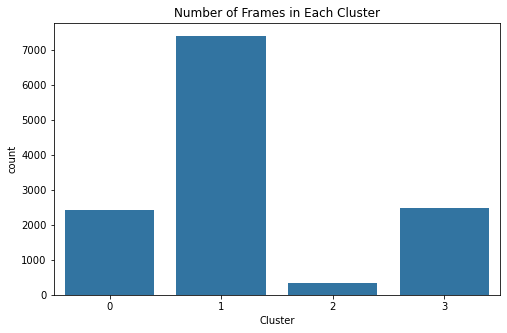

In [93]:
k = 4  # Choose number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize cluster distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=clean_df)
plt.title("Number of Frames in Each Cluster")
plt.show()

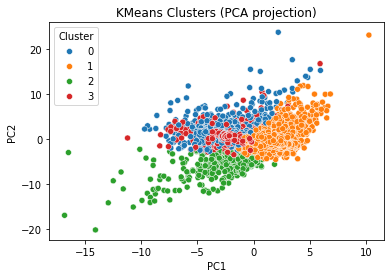

In [94]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clean_df['PC1'] = X_pca[:, 0]
clean_df['PC2'] = X_pca[:, 1]

sns.scatterplot(data=clean_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters (PCA projection)")
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Average Silhouette Score: 0.2797


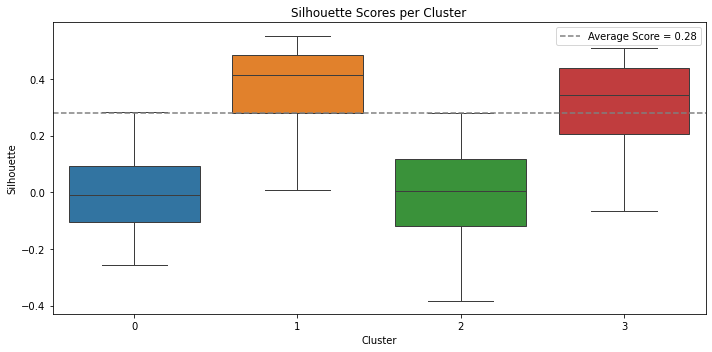

In [102]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 2: Compute silhouette scores
sil_scores = silhouette_samples(X_scaled, clean_df['Cluster'])
clean_df['Silhouette'] = sil_scores

# Step 3: Overall silhouette score
avg_score = silhouette_score(X_scaled, clean_df['Cluster'])
print(f"Average Silhouette Score: {avg_score:.4f}")

# Step 4: Visualize silhouette scores by cluster
plt.figure(figsize=(10, 5))
sns.boxplot(x='Cluster', y='Silhouette', data=clean_df, palette='tab10')
plt.title("Silhouette Scores per Cluster")
plt.axhline(avg_score, color='gray', linestyle='--', label=f'Average Score = {avg_score:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


Cluster 3 could represent a distinct and consistently repeated pose (e.g., sitting, standing upright)

Cluster 2 might represent noise, transitions, or unusual movements

Cluster 0 and 1 may represent variations of a common motion, such as walking or arm swinging

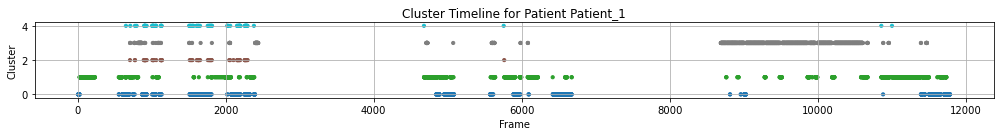

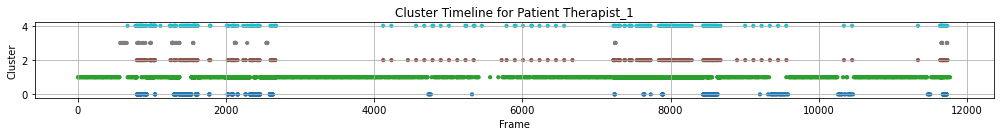

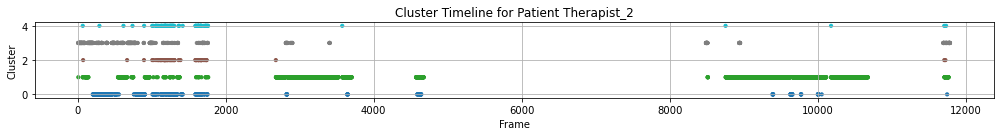

In [111]:
def plot_cluster_timeline(df, patient_id):
    df_patient = df[df['Patient'] == patient_id].sort_values('Frame')
    plt.figure(figsize=(14, 2))
    plt.scatter(df_patient['Frame'], df_patient['Cluster'], c=df_patient['Cluster'], cmap='tab10', s=10)
    plt.title(f"Cluster Timeline for Patient {patient_id}")
    plt.xlabel("Frame")
    plt.ylabel("Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_cluster_timeline(clean_df, 'Patient_1')
plot_cluster_timeline(clean_df, 'Therapist_1')
plot_cluster_timeline(clean_df, 'Therapist_2')

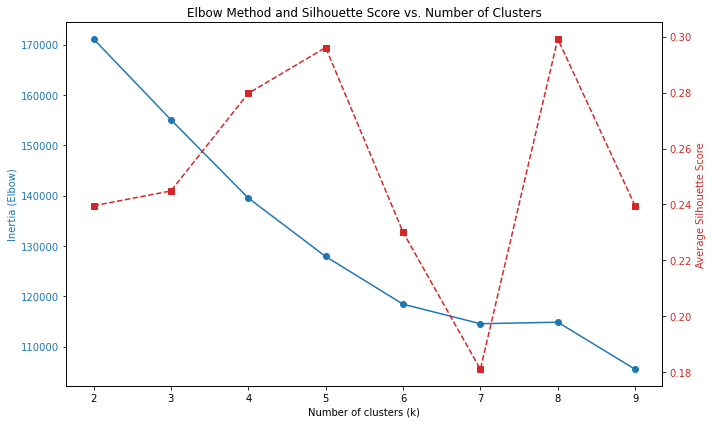

In [103]:
cluster_range = range(2, 10)  # You can extend this to, e.g., 2–15

inertia_scores = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertia_scores.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(sil_score)

# Plot Elbow and Silhouette Score together
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(cluster_range, inertia_scores, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(list(cluster_range))

# Add silhouette on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Silhouette Score', color=color)
ax2.plot(cluster_range, silhouette_scores, marker='s', linestyle='--', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

# Title
plt.title('Elbow Method and Silhouette Score vs. Number of Clusters')
fig.tight_layout()
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


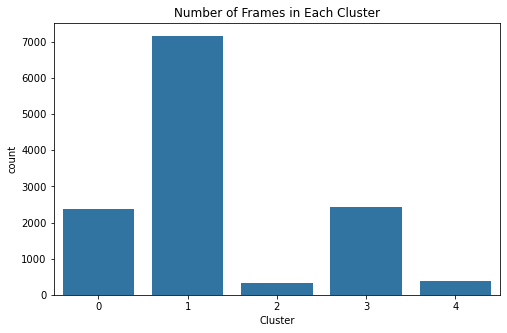

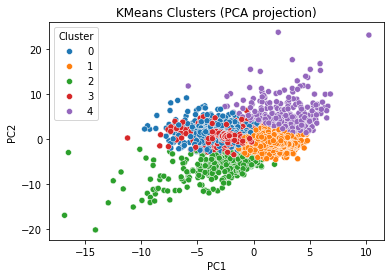

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Average Silhouette Score: 0.2961


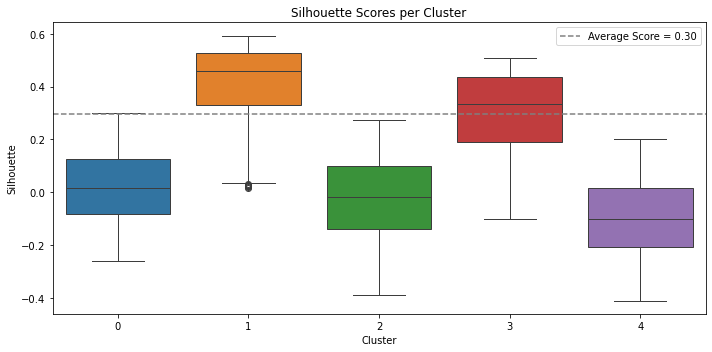

In [110]:
k = 5  # Choose number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize cluster distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=clean_df)
plt.title("Number of Frames in Each Cluster")
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clean_df['PC1'] = X_pca[:, 0]
clean_df['PC2'] = X_pca[:, 1]

sns.scatterplot(data=clean_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters (PCA projection)")
plt.show()

# Step 2: Compute silhouette scores
sil_scores = silhouette_samples(X_scaled, clean_df['Cluster'])
clean_df['Silhouette'] = sil_scores

# Step 3: Overall silhouette score
avg_score = silhouette_score(X_scaled, clean_df['Cluster'])
print(f"Average Silhouette Score: {avg_score:.4f}")

# Step 4: Visualize silhouette scores by cluster
plt.figure(figsize=(10, 5))
sns.boxplot(x='Cluster', y='Silhouette', data=clean_df, palette='tab10')
plt.title("Silhouette Scores per Cluster")
plt.axhline(avg_score, color='gray', linestyle='--', label=f'Average Score = {avg_score:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

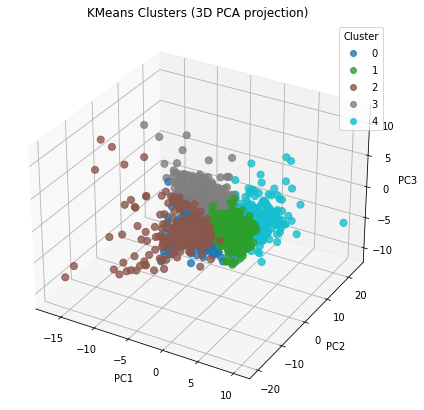

In [112]:
from mpl_toolkits.mplot3d import Axes3D  # Enables 3D plotting

# 3D PCA transformation
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Add the PCA components to the dataframe
clean_df['PC1'] = X_pca[:, 0]
clean_df['PC2'] = X_pca[:, 1]
clean_df['PC3'] = X_pca[:, 2]

# 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Map clusters to colors
scatter = ax.scatter(
    clean_df['PC1'],
    clean_df['PC2'],
    clean_df['PC3'],
    c=clean_df['Cluster'],
    cmap='tab10',
    s=50,
    alpha=0.8
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("KMeans Clusters (3D PCA projection)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()
